# Pytorch classification 101

Pytorch will be used as the preferred deep learning framework for this course. It can feel overwhelming to solve the assignments with no prior experience with pytorch. This notebook is supposed to give a short introduction, hopefully with usefull examples.

This notebook assumes that you have basic knowledge about neural networks and deep learning. Key concepts which should be known before reading this notebook are: linear layers, convolutional layers, activation functions, loss functions, backpropagation and gradient descent.

## Loading a dataset

Pytorch provides functionality for loading alot of existing dataset formats. The documentation can be found [here](https://pytorch.org/docs/stable/torchvision/datasets.html). In this section we will use pytorch's MNIST functionality to download and load the MNIST dataset. If you want to use your own dataset you should read the torch documentation and see if any of the implemented datasets can work for you. For instance the [image folder dataset](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) may work well for classification tasks. If not you may need to write your own dataset functionality.

We must provide the dataset to a dataloader which will sample the data appropriately for us. To the dataset we also supply a transformation which will be applied to all images. In our case this is simply a transformation to torch tensor.

In [36]:
from torchvision import datasets
import torchvision
import torch
dataset = datasets.MNIST("data/", train=True, download=True, transform = torchvision.transforms.ToTensor())

data_loader = torch.utils.data.DataLoader(dataset,
                                          batch_size=8, shuffle=True)

## Classification network - minimal working example
Torch provides all sorts of network layers in its [nn module](https://pytorch.org/docs/stable/nn.html). Here we will demonstrate how to define a simple layer and loss function, forward a batch and back-propagate the result.

Some important factors to remember:
* Since we use linear layers we must reshape the images into tensores of dimension [batch size, hxw].
* We must always reset the gradient before back propagating the loss.
* Torch's cross entropy loss already includes a softmax layer, so we do not need to provide an activation layer ourselves
* We can iterate over the data loader with a for-loop. It will loop through all images.

In [22]:
#Mnist images are of size 28x28
#Define a linear layer with 28x28 input nodes and 10 output classes
fc = torch.nn.Linear(in_features = 28*28, out_features = 10)

#Define a loss function
loss_function = torch.nn.CrossEntropyLoss()

#Learning rate
lr = 0.005

#The data loader iterates over all images and ground truths
for iteration, (images, targets) in enumerate(data_loader):
    
    #Reshape images into shappe [batchsize, 28x28]
    images = images.view(-1, 28*28)
    
    #Forward the images through the linear layer
    output = fc(images)
    
    #Forward the network output through the loss function
    loss = loss_function(output, targets)
    
    #Reset gradients before back-propagation
    fc.zero_grad()
    
    #Backpropagate the result
    loss.backward()
    
    #Print loss
    if(iteration%500 == 0):
        print(f"Iteration: {iteration}, Loss: {loss.detach().item()}")
    
    #Perform gradient step
    for param in fc.parameters():
        param.data -= param.grad.data*lr

Iteration: 0, Loss: 2.2789926528930664
Iteration: 500, Loss: 1.1308016777038574
Iteration: 1000, Loss: 0.4289010465145111
Iteration: 1500, Loss: 0.4484846293926239
Iteration: 2000, Loss: 0.6290685534477234
Iteration: 2500, Loss: 0.6348029375076294
Iteration: 3000, Loss: 0.6117620468139648
Iteration: 3500, Loss: 0.19683994352817535
Iteration: 4000, Loss: 0.16155457496643066
Iteration: 4500, Loss: 0.6665973663330078
Iteration: 5000, Loss: 0.12096591293811798
Iteration: 5500, Loss: 0.47499194741249084
Iteration: 6000, Loss: 0.5097285509109497
Iteration: 6500, Loss: 0.5644869208335876
Iteration: 7000, Loss: 0.41368401050567627


## Creating a larger network
Whenever we want to define larger networks it is often practical to make our own subclass to the torch.nn module. Some may not be familiar with object oriented programming in python. A simple guide for that can be found [here](https://realpython.com/python3-object-oriented-programming/).

Here we will define a simple network with both convolutional layers and a linear classification layer.

Things to remeber:
* A minimal network overloads the `__init__` and the `forward` methods.
* We define our network layers in the object constructor
* Out channels and in channels must agree between conv layers
* If we overload the `forward()` function `torch.nn.Module` will automatically forward the input when we use the `__call__` operator.

In [34]:
class MyFirstNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        #Define our layers
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels = 4, kernel_size = 3) #Output 26*26*8
        self.conv2 = torch.nn.Conv2d(in_channels=4, out_channels = 8, kernel_size = 3,\
                                     stride=2, padding = 1) #Output = 13*13*8
        
        self.fc = torch.nn.Linear(in_features = 13*13*8, out_features = 10)
        
        #Function pointer to activation function
        self.rl = torch.nn.ReLU()
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.rl(x)
        
        x = self.conv2(x)
        x = self.rl(x)

        x = x.view(-1, 13*13*8)
        output = self.fc(x)
        return output
        

We could use the same training structure as in the minimal example. It would work in the exact same way. It is however, not common to do the gradient steps manually. Instead we use an [optimizer](https://pytorch.org/docs/stable/optim.html). The optimizer will hold our models parameters and do the gradient step for us.

In [70]:
#Define our network
model = MyFirstNetwork()

#Define a loss function
loss_function = torch.nn.CrossEntropyLoss()

#Define a stochastic gradient descent optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05)

#Iterate through all images using the data loader
for iteration, (images, targets) in enumerate(data_loader):
    
    #Forward the images through the linear layer
    output = model(images)
    
    #Forward the network output through the loss function
    loss = loss_function(output, targets)
    
    #Reset gradients before back-propagation
    optimizer.zero_grad()
    
    #Backpropagate the result
    loss.backward()
    
    #Perform gradient step
    optimizer.step()
    
    #Print loss
    if(iteration%500 == 0):
        print(f"Iteration: {iteration}, Loss: {loss.detach().item()}")
    
    

Iteration: 0, Loss: 2.33815860748291
Iteration: 500, Loss: 0.27748674154281616
Iteration: 1000, Loss: 0.0884331539273262
Iteration: 1500, Loss: 0.11556092649698257
Iteration: 2000, Loss: 0.626777708530426
Iteration: 2500, Loss: 0.3832801878452301
Iteration: 3000, Loss: 0.009281393140554428
Iteration: 3500, Loss: 0.028962550684809685
Iteration: 4000, Loss: 0.0015657392796128988
Iteration: 4500, Loss: 0.007039709482342005
Iteration: 5000, Loss: 0.020890386775135994
Iteration: 5500, Loss: 0.035504717379808426
Iteration: 6000, Loss: 0.08626484870910645
Iteration: 6500, Loss: 0.1787303239107132
Iteration: 7000, Loss: 0.00824312400072813


### Torch sequential

You may come across examples that use [torch.nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential). It is a container that we can use when defining multiple sequential layers. It makes the code simpler and perhaps more readable. 

The following class defines the exact same network as above, but with fewer lines of code.

In [38]:
class MySecondNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        #Define our layers
        self.convLayers = torch.nn.Sequential(torch.nn.Conv2d(1,4,3),
                                              torch.nn.ReLU(),
                                              torch.nn.Conv2d(4, 8, kernel_size = 3, stride=2, padding = 1),
                                              torch.nn.ReLU())
        self.fc = torch.nn.Linear(in_features = 13*13*8, out_features = 10)
        
    
    def forward(self, x):
        x = self.convLayers(x)

        x = x.view(-1, 13*13*8)
        output = self.fc(x)
        return output
        

## Testing the model
When we have trained a model, the most interesting part is to test it. Here we will show how to get the predictions from the model.

In [68]:
#First we need to load the testing dataset
dataset = datasets.MNIST("data/", train=False, download=True, transform = torchvision.transforms.ToTensor())

test_loader = torch.utils.data.DataLoader(dataset,
                                          batch_size=1, shuffle=True)

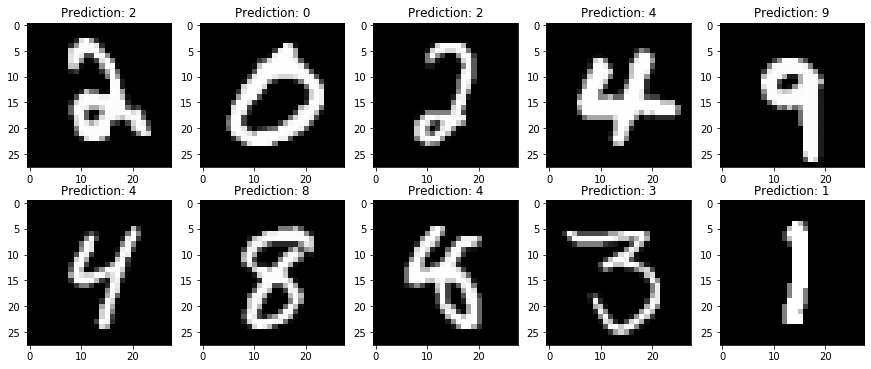

In [72]:
import numpy as np
from matplotlib import pyplot as plt

#We do not need gradients when testing
with torch.no_grad():
    #Set the model into evaluation mode
    model.eval()
    
    plt.figure(figsize = (15, 6))
    for i in range(10):
        #Get next image from data loader
        image, _ = next(iter(test_loader))
        
        
        output = model(image)
        
        #Output is of shape [batches, classes]
        #The prediction is the argmax over the classes
        prediction = output.argmax(dim=1).squeeze()
        
        #To display the image we convert it from torch tensor to numpy
        image_np = image.numpy().reshape((28,28))
        
        plt.subplot(2,5,i+1)
        plt.imshow(image_np, cmap = "gray")
        plt.title(f"Prediction: {prediction}")

    